In [1]:
%cd /home/dragon82/dragon82/seoyeon/

/home/dragon82/dragon82/seoyeon


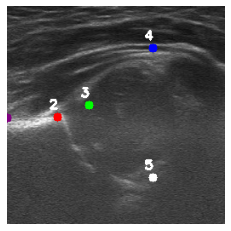

In [2]:
import matplotlib.pyplot as plt
import cv2

name = 1000029
image = cv2.imread(f'./_mskultra/img/{name}.jpg')

# Open the annotation file and read the data
with open(f'./_mskultra/del_annotation/{name}.txt', "r") as bboxes:
    data = bboxes.readlines()

# Parse coordinates and create a list
coordinates = []
for line in data:
    x, y = map(int, line.strip().split())
    coordinates.append((x, y))

# Define colors for each point
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 255), (0, 0, 0), (128, 0, 128)]  # Red, Green, Blue, White, Black, Purple

# Define labels for each point
labels = ['1', '2', '3', '4', '5']

# Draw circles for each coordinate on the image with different colors and labels
for i, (point, label) in enumerate(zip(coordinates, labels)):
    color = colors[i-1]  # Cycle through colors
    cv2.circle(image, point, 5, color, -1)  # Circle with filled center
    cv2.putText(image, label, (point[0] - 10, point[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

# Convert image from BGR to RGB (matplotlib uses RGB)
# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()


In [18]:
import os

# 주어진 폴더 내의 모든 파일 목록 가져오기
def list_files(directory, extension):
    files = []
    for file in os.listdir(directory):
        if file.endswith(extension):
            files.append(os.path.join(directory, file))
    return files

# 좌표 데이터를 새로운 형식의 데이터로 변환하는 함수
def convert_annotation(old_path, new_path, w, h, img_size):
    with open(old_path, "r") as old_file:
        data = old_file.read()
    lines = data.strip().split('\n')
    
    new_data = ""
    object_num = 0
    for k in range(len(lines)):
        x, y = map(int, lines[k].split())
        new_data += f"{object_num} {x/img_size} {y/img_size} {w/img_size} {h/img_size}\n"
        object_num += 1 

    with open(new_path, "w") as new_file:
        new_file.write(new_data)

# 주어진 경로의 모든 annotation 파일에 대해 변환 수행
def convert_all_annotations(folder_path, new_path, w, h,img_size):
    # 주어진 경로에 있는 모든 파일 목록 가져오기
    annotation_files = list_files(folder_path, ".txt")

    # 각 파일에 대해 변환 수행
    for file_path in annotation_files:
        # 새로운 파일 경로 생성
        file_name = os.path.basename(file_path)
        new_file_path = os.path.join(new_path, file_name)
        # 좌표 데이터 변환 수행
        convert_annotation(file_path, new_file_path, w, h, img_size)

# 주어진 폴더의 모든 annotation 파일 변환하기
folder_path = '/home/dragon82/dragon82/seoyeon/_mskultra/del_annotation/'
new_path = '/home/dragon82/dragon82/seoyeon/_mskultra/yolo_annotation_64/'
img_size = 256  # 실제 이미지 크기에 맞게 수정해야 함
convert_all_annotations(folder_path, new_path, 32, 32, img_size)

In [20]:
import os
import shutil
import random

def train_valid_test_split(image_path, annotation_path,new_path, train_ratio=0.8, valid_ratio=0.1):
    # 이미지 파일 및 annotation 파일 목록 획득
    image_files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f)) and f.endswith('.jpg')]
    annotation_files = [f for f in os.listdir(annotation_path) if os.path.isfile(os.path.join(annotation_path, f)) and f.endswith('.txt')]
    
    # 랜덤하게 섞기
    random.shuffle(image_files)
    
    # 분할 인덱스 계산
    num_images = len(image_files)
    num_train = int(num_images * train_ratio)
    num_valid = int(num_images * valid_ratio)
    num_test = num_images - num_train - num_valid
    
    # train, valid, test 폴더 생성
    train_folder = os.path.join(new_path, 'images/train')
    valid_folder = os.path.join(new_path, 'images/val')
    test_folder = os.path.join(new_path, 'images/test')
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(valid_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    
    # labels 폴더 생성
    labels_train_folder = os.path.join(new_path, 'labels/train')
    labels_valid_folder = os.path.join(new_path, 'labels/val')
    labels_test_folder = os.path.join(new_path, 'labels/test')
    os.makedirs(labels_train_folder, exist_ok=True)
    os.makedirs(labels_valid_folder, exist_ok=True)
    os.makedirs(labels_test_folder, exist_ok=True)
    
    # 이미지 및 annotation 파일 복사
    for i, image_file in enumerate(image_files):
        src_image_path = os.path.join(image_path, image_file)
        if i < num_train:
            dest_image_path = os.path.join(train_folder, image_file)
            annotation_dest_folder = labels_train_folder
        elif i < num_train + num_valid:
            dest_image_path = os.path.join(valid_folder, image_file)
            annotation_dest_folder = labels_valid_folder
        else:
            dest_image_path = os.path.join(test_folder, image_file)
            annotation_dest_folder = labels_test_folder
        shutil.copy(src_image_path, dest_image_path)
        
        # 이미지 파일에 대응하는 annotation 파일 찾기
        annotation_file_name = os.path.splitext(image_file)[0] + '.txt'
        src_annotation_path = os.path.join(annotation_path, annotation_file_name)
        dest_annotation_path = os.path.join(annotation_dest_folder, annotation_file_name)
        if os.path.exists(src_annotation_path):
            shutil.copy(src_annotation_path, dest_annotation_path)
    
    print(f"이미지 및 annotation 파일 분할이 완료되었습니다.")
    print(f"학습 이미지 수: {num_train}, 검증 이미지 수: {num_valid}, 테스트 이미지 수: {num_test}")

# 이미지 및 annotation 폴더 경로
image_path = '/home/dragon82/dragon82/seoyeon/_mskultra/img/'
annotation_path = '/home/dragon82/dragon82/seoyeon/_mskultra/yolo_annotation_64/'
new_path = '/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1/'

# 이미지 및 annotation 파일을 train, valid, test로 분할 (기본 비율: 6:2:2)
train_valid_test_split(image_path, annotation_path, new_path, train_ratio=0.6, valid_ratio=0.2)

이미지 및 annotation 파일 분할이 완료되었습니다.
학습 이미지 수: 1693, 검증 이미지 수: 564, 테스트 이미지 수: 565


In [21]:
# train 폴더와 test 폴더 생성 확인
from glob import glob

train_img_list = glob('/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1/images/train/*.jpg')
test_img_list = glob('/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1/images/test/*.jpg')
val_img_list = glob('/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1/images/val/*.jpg')


# 파일 쓰기
with open('/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/train1.txt', 'w') as f:
  f.write('\n'.join(train_img_list) + '\n')

with open('/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/val1.txt', 'w') as f:
  f.write('\n'.join(val_img_list) + '\n')
                     
with open('/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/test1.txt', 'w') as f:
  f.write('\n'.join(test_img_list) + '\n')

In [3]:
#w,h 32로 진행해야함. 
%cd /home/dragon82/dragon82/seoyeon/ultralytics/ultralytics
!echo insecure >> ~/.curlrc
!yolo detect device=0 train data=./datasets/data1.yaml model=./models/yolov8x.yaml pretrained=./models/yolov8x.pt epochs=150 batch=16 imgsz=640 save=True name="yolov8x_class5"

/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics
Transferred 589/595 items from pretrained weights
Ultralytics YOLOv8.2.2 🚀 Python-3.8.10 torch-1.8.0+cu111 CUDA:0 (RTX A6000, 48685MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=./models/yolov8x.yaml, data=./datasets/data1.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8x_class5, exist_ok=False, pretrained=./models/yolov8x.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augme

# predict 진행 

In [4]:
%cd /home/dragon82/dragon82/seoyeon/ultralytics/ultralytics
!echo insecure >> ~/.curlrc
!yolo detect predict model=./runs/detect/yolov8x_class5/weights/last.pt source=./datasets/cancer1/images/test save_txt # predict with custom model

/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics
Ultralytics YOLOv8.2.2 🚀 Python-3.8.10 torch-1.8.0+cu111 CUDA:0 (RTX A6000, 48685MiB)
YOLOv8x summary (fused): 268 layers, 68128383 parameters, 0 gradients, 257.4 GFLOPs

image 1/565 /home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1/images/test/1000016.jpg: 640x640 2 1s, 1 2, 2 3s, 1 4, 1 5, 24.8ms
image 2/565 /home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1/images/test/1000022.jpg: 640x640 1 1, 2 2s, 1 3, 1 4, 1 5, 24.8ms
image 3/565 /home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1/images/test/1000023.jpg: 640x640 2 1s, 1 2, 1 3, 1 4, 1 5, 24.7ms
image 4/565 /home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1/images/test/1000026.jpg: 640x640 2 1s, 1 2, 1 3, 1 4, 1 5, 24.4ms
image 5/565 /home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1/images/test/1000028.jpg: 640x640 2 1s, 1 2, 1 3, 1 4, 1 5, 25.0ms
image 6/565 /home

# 포인트별로 iou계산하기

In [21]:
import os
import numpy as np
import pandas as pd

# IoU 계산하는 함수
def calculate_iou(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    x_min1, y_min1, x_max1, y_max1 = x1-w1,y1-h1,x1+w1,y1+h1
    x_min2, y_min2, x_max2, y_max2 = x2-w2,y2-h2,x2+w2,y2+h2
    
    # 겹치는 영역의 좌표 계산
    x_intersection = max(0, min(x_max1, x_max2) - max(x_min1, x_min2))
    y_intersection = max(0, min(y_max1, y_max2) - max(y_min1, y_min2))
    intersection_area = x_intersection * y_intersection
    
    # 전체 영역의 좌표 계산
    box1_area = (x_max1 - x_min1) * (y_max1 - y_min1)
    box2_area = (x_max2 - x_min2) * (y_max2 - y_min2)
    union_area = box1_area + box2_area - intersection_area
    
    # IoU 계산
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou


# 원본 및 예측된 바운딩 박스 파일 경로 설정
GT_bbox_dir = '/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1/labels/test'
detected_bbox_dir = '/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/runs/detect/predict/labels'

# 이미지 파일의 리스트 가져오기
image_files = os.listdir(GT_bbox_dir)

# 이미지 이름과 IoU 값을 저장할 리스트 초기화
image_names = []
labels = []
iou_lst = []

# 각 이미지에 대해 IoU 계산
for image_file in image_files:
    # 원본 및 예측된 바운딩 박스 파일 경로 설정
    GT_bbox_path = os.path.join(GT_bbox_dir, image_file)
    detected_bbox_path = os.path.join(detected_bbox_dir, image_file)

    # 예측된 바운딩 박스 파일이 존재하는 경우에만 계산 수행
    if os.path.exists(detected_bbox_path):
        # 파일 읽기
        with open(detected_bbox_path, 'r') as f:
            detected_lines = f.readlines()

        with open(GT_bbox_path, 'r') as f:
            GT_lines = f.readlines()
        
        for det_line in  detected_lines:
            # 좌표를 추출합니다.
            on1, det_x, det_y, det_w, det_h = map(float, det_line.strip().split())
            det_bbox = (det_x, det_y, det_w, det_h)
            
            for GT_line in GT_lines:
                on2, GT_x, GT_y, GT_w, GT_h = map(float, GT_line.strip().split())
                if on1 == on2 :
                    GT_bbox = (GT_x, GT_y, GT_w, GT_h)
                    iou = calculate_iou(det_bbox, GT_bbox)
                    iou_lst.append(iou)
                    image_names.append(image_file)
                    labels.append(int(on1)+1)
                else: continue


# 데이터프레임 생성
df = pd.DataFrame({'Image_Name': image_names, 'label':labels, 'IoU': iou_lst})

# CSV 파일로 저장
output_csv_path = "/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/runs/detect/output_Iou/ious5.csv"
df.to_csv(output_csv_path, index=False)

# 전체 이미지에 대한 평균 IoU 계산
print(df.head(20))

     Image_Name  label       IoU
0   1000260.txt      2  0.990026
1   1000260.txt      3  0.987980
2   1000260.txt      1  0.243137
3   1000260.txt      5  0.984715
4   1000260.txt      4  0.980112
5   1000260.txt      1  0.500819
6   1001693.txt      2  0.984206
7   1001693.txt      4  0.986367
8   1001693.txt      3  0.991786
9   1001517.txt      2  0.996289
10  1001517.txt      4  0.983831
11  1001517.txt      1  0.243186
12  1001517.txt      3  0.991697
13  1000492.txt      2  0.984764
14  1000492.txt      3  0.984016
15  1000492.txt      5  0.984558
16  1000492.txt      4  0.989075
17  1000492.txt      1  0.244321
18  1000492.txt      1  0.493362
19  1000492.txt      4  0.798627


# 포인트별로 iou 평균 구하기  

In [22]:
iou1 = df[df['label'] == 1]
iou2 = df[df['label'] == 2]
iou3 = df[df['label'] == 3]
iou4 = df[df['label'] == 4]
iou5 = df[df['label'] == 5]
print(iou1.head())



     Image_Name  label       IoU
2   1000260.txt      1  0.243137
5   1000260.txt      1  0.500819
11  1001517.txt      1  0.243186
17  1000492.txt      1  0.244321
18  1000492.txt      1  0.493362


In [26]:
# 각 라벨에 대한 IoU 평균 계산
iou1_mean = iou1['IoU'].mean()
iou2_mean = iou2['IoU'].mean()
iou3_mean = iou3['IoU'].mean()
iou4_mean = iou4['IoU'].mean()
iou5_mean = iou5['IoU'].mean()

# 각 평균값을 데이터프레임으로 생성
mean_df = pd.DataFrame({'Label': [1, 2, 3, 4, 5], 'Mean_IoU': [iou1_mean, iou2_mean, iou3_mean, iou4_mean, iou5_mean]})

print(mean_df)

import numpy as np
mean_iou = [iou1_mean, iou2_mean, iou3_mean, iou4_mean, iou5_mean]
tot_mean = np.mean(mean_iou)
print('mean IoU of 5 points:',tot_mean)

   Label  Mean_IoU
0      1  0.358205
1      2  0.974353
2      3  0.964319
3      4  0.947752
4      5  0.982439
mean IoU of 5 points: 0.845413683706712


# local detection

In [37]:
# machine learning module
import numpy as np
import pandas as pd

# ANN module
import torch
from torch import nn, optim                           # torch 에서 제공하는 신경망 기술, 손실함수, 최적화를 할 수 있는 함수들을 불러온다.
from torch.utils.data import DataLoader, Dataset      # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리.
import torch.nn.functional as F                       # torch 내의 세부적인 기능을 불러옴.

# Loss
from sklearn.metrics import mean_squared_error        # regression 문제의 모델 성능 측정을 위해서 MSE를 불러온다.

import matplotlib.pyplot as plt

In [128]:
import os
import pandas as pd

original_labels_dir = '/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1/labels/test'
predicted_labels_dir = '/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/runs/detect/predict/labels'
output_csv_path = '/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/runs/detect/output_mse/data1.csv'

# 파일 이름을 추출하는 함수
def extract_filename(file_path):
    return os.path.splitext(os.path.basename(file_path))[0]

# txt 파일에서 데이터를 읽어오는 함수
def read_txt_file(file_path):
    with open(file_path, 'r') as file:
        data = file.read().splitlines()
    return data

# train.csv 파일을 생성하는 함수
def create_train_csv(predicted_dir, output_path):
    # 파일들의 리스트를 가져옴
    predict_files = os.listdir(predicted_dir)
    
    # 데이터를 저장할 리스트 생성
    data = []
    
    # 각 파일에 대해 처리
    for file in predict_files:
        # 파일 이름 추출
        filename = extract_filename(file)
        
        # predicted_labels_dir에서 해당 파일에 대한 경로 찾기
        predicted_file_path = os.path.join(predicted_labels_dir, f"{filename}.txt")
        original_file_path = os.path.join(original_labels_dir, f"{filename}.txt")
        
        # txt 파일에서 데이터 읽어오기
        predicted_data = read_txt_file(predicted_file_path)
        original_data = read_txt_file(original_file_path)
        
    
        # 데이터를 data.csv에 추가
        for point in predicted_data: 
            min_distance = float('inf')  # 최소 거리를 저장할 변수 초기화
            predicted_values = point.split()
            # x_predict, y_predict, width, height 가져오기
            ob , x_predict, y_predict, width, height = map(float, predicted_values)
            
            #original 파일의 center 값 중 가장 가까운 값을 가져오기 
            for original in original_data: 
                orginal_values = original.split()
                ob_c, x_c, y_c = map(float,orginal_values[:3])
                if ob == ob_c:
                    # 데이터 추가
                    data.append([filename, int(ob)+1, x_predict, y_predict, width, height,x_c, y_c])
                else: continue
    
    # 데이터프레임 생성
    df = pd.DataFrame(data, columns=['image_name','label', 'x_predict', 'y_predict', 'width', 'height', 'x_real', 'y_real'])
    
    # CSV 파일로 저장
    df.to_csv(output_path, index=False)
    return df

# train.csv 생성
df=create_train_csv(predicted_labels_dir, output_csv_path)
print(df.head(10))
print(len(df))

  image_name  label  x_predict  y_predict     width    height    x_real  \
0    1000260      2   0.230820   0.507169  0.125156  0.125906  0.230469   
1    1000260      3   0.374602   0.453481  0.124248  0.124245  0.375000   
2    1000260      1   0.015297   0.512720  0.030526  0.125199  0.000000   
3    1000260      5   0.668618   0.786438  0.124875  0.125470  0.667969   
4    1000260      4   0.668844   0.190538  0.125106  0.126652  0.667969   
5    1000260      1   0.031403   0.512270  0.062805  0.125041  0.000000   
6    1001693      2   0.230622   0.507320  0.125628  0.126371  0.230469   
7    1001693      4   0.667871   0.191968  0.123847  0.125238  0.667969   
8    1001693      3   0.374996   0.452756  0.124340  0.124719  0.375000   
9    1001517      2   0.230661   0.507676  0.125012  0.125273  0.230469   

     y_real  
0  0.507812  
1  0.453125  
2  0.511719  
3  0.785156  
4  0.191406  
5  0.511719  
6  0.507812  
7  0.191406  
8  0.453125  
9  0.507812  
3031


In [31]:
2436*0.8 #train len
data = pd.read_csv('/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/runs/detect/output_mse/data1.csv')
train = data[:1948]
test = data[1948:]
len(train)

1948

In [32]:
col_id = ['image_name']
col_x = ['x_predict', 'y_predict', 'width', 'height']
col_y = ['x_real', 'y_real']

x_train = train[col_x]
y_train = train[col_y]

x_test = test[col_x]
y_test = test[col_y]

x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy().reshape(-1,2)
print(y_test)

[[0.         0.51171875]
 [0.66796875 0.19140625]
 [0.         0.51171875]
 ...
 [0.66796875 0.19140625]
 [0.         0.51171875]
 [0.         0.51171875]]


In [35]:
test.head()

,image_name,label,x_predict,y_predict,width,height,x_real,y_real
1948,1000911,1,0.030957,0.512111,0.061914,0.124273,0.000000,0.511719
1949,1000911,4,0.668730,0.191010,0.125325,0.126942,0.667969,0.191406
1950,1000911,1,0.014764,0.512856,0.029527,0.124182,0.000000,0.511719
1951,1000911,2,0.201082,0.508614,0.123768,0.124414,0.230469,0.507812
1952,1001293,2,0.230704,0.507602,0.125507,0.125462,0.230469,0.507812


In [38]:
# torch의 Dataset 을 상속.
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [39]:
# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(x_test, y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

In [43]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(4, 50, bias=True) # 입력층(13) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(50, 30, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(30, 2, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.


    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
      
        return x

In [44]:
model = MLP()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [45]:
loss_ = [] # loss를 저장할 리스트.
n = len(trainloader)
num_epoch = 400
for epoch in range(1,num_epoch+1):

  running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.

  for i, data in enumerate(trainloader, 0): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.
    
    inputs, values = data # data에는 X, Y가 들어있다.

    optimizer.zero_grad() # 최적화 초기화.

    outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
    loss = criterion(outputs, values) # 손실함수를 계산. error 계산.
    loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.
    optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

    running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
  
  loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산
  
  if epoch % 10 == 0:
    print('Epoch [{}/{}], Loss: {}'.format(
      epoch, num_epoch, running_loss/n))


Epoch [10/400], Loss: 0.0891164679263459
Epoch [20/400], Loss: 0.00651258979084306
Epoch [30/400], Loss: 0.003960429352982978
Epoch [40/400], Loss: 0.003656727267566641
Epoch [50/400], Loss: 0.002734268899075687
Epoch [60/400], Loss: 0.0024305012036061496
Epoch [70/400], Loss: 0.0028361461161574746
Epoch [80/400], Loss: 0.0023940416223743595
Epoch [90/400], Loss: 0.002861381984090616
Epoch [100/400], Loss: 0.0024566103438999442
Epoch [110/400], Loss: 0.0027006678712615346
Epoch [120/400], Loss: 0.0022291520602817907
Epoch [130/400], Loss: 0.0019375495622163546
Epoch [140/400], Loss: 0.0018503471071541799
Epoch [150/400], Loss: 0.0020117355218599933
Epoch [160/400], Loss: 0.0017194532876124331
Epoch [170/400], Loss: 0.0018176629311084504
Epoch [180/400], Loss: 0.0015893527573799012
Epoch [190/400], Loss: 0.0016761910576816098
Epoch [200/400], Loss: 0.0016963892791908785
Epoch [210/400], Loss: 0.0016791941426297437
Epoch [220/400], Loss: 0.0018154640899604706
Epoch [230/400], Loss: 0.001

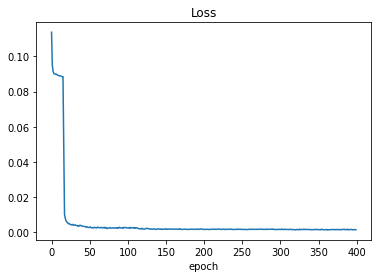

In [46]:
plt.plot(loss_)
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [47]:
def evaluation(dataloader):

  predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
  actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.

  with torch.no_grad():
    model.eval() # 평가를 할 땐 반드시 eval()을 사용해야 한다.

    for data in dataloader:
      inputs, values = data
      outputs = model(inputs)

      predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
      actual = torch.cat((actual, values), 0) # cat함수를 통해 실제값을 누적.

  predictions = predictions.numpy() # 넘파이 배열로 변경.
  actual = actual.numpy() # 넘파이 배열로 변경.
  rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용해 RMSE를 계산.

  return predictions , rmse

In [48]:
test_predictions , test_rmse = evaluation(testloader)

print(f'test rmse:{test_rmse}')

test rmse:0.009188706986606121


In [49]:
len(test_predictions)
test_predictions

array([[0.        , 0.5089591 ],
       [0.6550442 , 0.20819697],
       [0.        , 0.5100895 ],
       ...,
       [0.65551543, 0.20763555],
       [0.        , 0.5100363 ],
       [0.        , 0.50893366]], dtype=float32)

In [50]:
#RMSE 계산하기

test_id = test[col_id].values.flatten()
test_label = test['label'].values.flatten()

result_df = pd.DataFrame({'img': test_id,'label':test_label, 'predict_x': [pred[0] for pred in test_predictions], 'predict_y': [pred[1] for pred in test_predictions],'real_x':test['x_real'],'real_y':test['y_real']})
print(result_df.head())

          img  label  predict_x  predict_y    real_x    real_y
1948  1000911      1   0.000000   0.508959  0.000000  0.511719
1949  1000911      4   0.655044   0.208197  0.667969  0.191406
1950  1000911      1   0.000000   0.510090  0.000000  0.511719
1951  1000911      2   0.229085   0.502264  0.230469  0.507812
1952  1001293      2   0.245295   0.502155  0.230469  0.507812


In [74]:
import numpy as np

# Calculate RMSE for each row
result_df['rmse'] = np.sqrt((result_df['predict_x'] - result_df['real_x']) ** 2 + (result_df['predict_y'] - result_df['real_y']) ** 2)

print(result_df.head(30))

          img  label  predict_x  predict_y    real_x    real_y      rmse
1948  1000911      1   0.000000   0.508959  0.000000  0.511719  0.002760
1949  1000911      4   0.655044   0.208197  0.667969  0.191406  0.021189
1950  1000911      1   0.000000   0.510090  0.000000  0.511719  0.001629
1951  1000911      2   0.229085   0.502264  0.230469  0.507812  0.005718
1952  1001293      2   0.245295   0.502155  0.230469  0.507812  0.015869
1953  1001293      3   0.376668   0.464241  0.375000  0.453125  0.011241
1954  1001293      1   0.000000   0.510040  0.000000  0.511719  0.001678
1955  1000687      1   0.000000   0.508938  0.000000  0.511719  0.002780
1956  1000687      3   0.377424   0.463515  0.375000  0.453125  0.010669
1957  1000687      2   0.245019   0.502157  0.230469  0.507812  0.015611
1958  1000687      1   0.000000   0.510050  0.000000  0.511719  0.001669
1959  1000687      5   0.670438   0.787890  0.667969  0.785156  0.003683
1960  1001873      5   0.670326   0.787766  0.66796

In [52]:
result_df.to_csv('/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/runs/detect/output_mse/predict_point1.csv', index=False)

In [69]:
rmse1=result_df[result_df['label']==1]
rmse2=result_df[result_df['label']==2]
rmse3=result_df[result_df['label']==3]
rmse4=result_df[result_df['label']==4]
rmse5=result_df[result_df['label']==5]
rmse1_mean=rmse1['rmse'].mean()
rmse2_mean=rmse2['rmse'].mean()
rmse3_mean=rmse3['rmse'].mean()
rmse4_mean=rmse4['rmse'].mean()
rmse5_mean=rmse5['rmse'].mean()

In [73]:
# 각 평균값을 데이터프레임으로 생성
mean_mse = pd.DataFrame({'Label': [1, 2, 3, 4, 5], 'Mean_mse': [rmse1_mean, rmse2_mean, rmse3_mean, rmse4_mean, rmse5_mean]})

print(mean_mse)

import numpy as np
mean_rmse_tot =  [rmse1_mean, rmse2_mean, rmse3_mean, rmse4_mean, rmse5_mean]
tot_mse = np.mean(mean_rmse_tot)
print('mean RMSE of 5 points:',tot_mse)

   Label  Mean_mse
0      1  0.002194
1      2  0.015273
2      3  0.012466
3      4  0.023721
4      5  0.003925
mean RMSE of 5 points: 0.011515494874084478


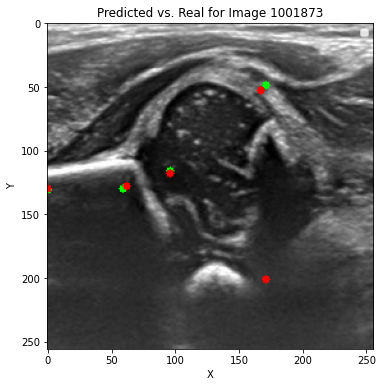

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image


# 이미지 경로
image_path = "/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1/images/test/"

def plot_image_with_points(img_id, img_data):
    # 이미지 불러오기
    image = cv2.imread(image_path + f"{img_id}.jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image from BGR to RGB (matplotlib uses RGB)

    # 이미지에 점 찍기
    for i in range(len(img_data)):
        cor_pre = (int(img_data.iloc[i]['predict_x'] * image.shape[1]), int(img_data.iloc[i]['predict_y'] * image.shape[0]))
        cor_real = (int(img_data.iloc[i]['real_x'] * image.shape[1]), int(img_data.iloc[i]['real_y'] * image.shape[0]))
      # Circle with filled center
        cv2.circle(image, cor_real, 3, (0, 255, 0), -1)
        cv2.circle(image, cor_pre, 3, (255, 0, 0), -1)

    # 이미지 보여주기
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Predicted vs. Real for Image {img_id}')
    plt.legend(['Predicted', 'Real'])
    plt.grid(False)
    plt.show()

# 이미지 ID
img_id = 1001873
img_data = result_df[result_df['img'] == img_id]

# 이미지에 점 찍기
plot_image_with_points(img_id, img_data)

In [108]:
idx = result_df['img'].values

In [109]:
im_lst = []
for img_id in idx :
    if len(result_df[result_df['img'] == img_id]) == 5:
        im_lst.append(img_id)
print(im_lst[:20])

[1000687, 1000687, 1000687, 1000687, 1000687, 1000551, 1000551, 1000551, 1000551, 1000551, 1001188, 1001188, 1001188, 1001188, 1001188, 1002137, 1002137, 1002137, 1002137, 1002137]


In [110]:
for i in im_lst:
    label = result_df[result_df['img'] == i]['label'].values
    print(i,label)

1000687 [1 3 2 1 5]
1000687 [1 3 2 1 5]
1000687 [1 3 2 1 5]
1000687 [1 3 2 1 5]
1000687 [1 3 2 1 5]
1000551 [2 1 1 3 5]
1000551 [2 1 1 3 5]
1000551 [2 1 1 3 5]
1000551 [2 1 1 3 5]
1000551 [2 1 1 3 5]
1001188 [2 3 4 1 5]
1001188 [2 3 4 1 5]
1001188 [2 3 4 1 5]
1001188 [2 3 4 1 5]
1001188 [2 3 4 1 5]
1002137 [2 3 4 5 1]
1002137 [2 3 4 5 1]
1002137 [2 3 4 5 1]
1002137 [2 3 4 5 1]
1002137 [2 3 4 5 1]
1001383 [2 4 3 5 1]
1001383 [2 4 3 5 1]
1001383 [2 4 3 5 1]
1001383 [2 4 3 5 1]
1001383 [2 4 3 5 1]
1001804 [5 2 1 3 1]
1001804 [5 2 1 3 1]
1001804 [5 2 1 3 1]
1001804 [5 2 1 3 1]
1001804 [5 2 1 3 1]
1001741 [3 2 1 5 1]
1001741 [3 2 1 5 1]
1001741 [3 2 1 5 1]
1001741 [3 2 1 5 1]
1001741 [3 2 1 5 1]
1000141 [2 3 1 5 1]
1000141 [2 3 1 5 1]
1000141 [2 3 1 5 1]
1000141 [2 3 1 5 1]
1000141 [2 3 1 5 1]
1001285 [2 4 3 5 1]
1001285 [2 4 3 5 1]
1001285 [2 4 3 5 1]
1001285 [2 4 3 5 1]
1001285 [2 4 3 5 1]
1001763 [2 3 5 1 1]
1001763 [2 3 5 1 1]
1001763 [2 3 5 1 1]
1001763 [2 3 5 1 1]
1001763 [2 3 5 1 1]


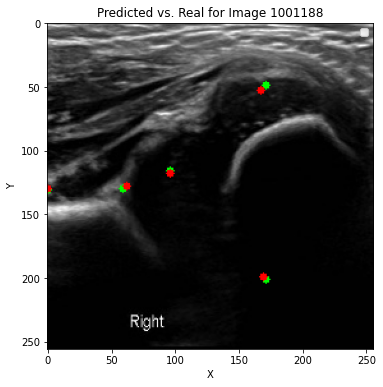

In [111]:
# 이미지 ID
img_id = 1001188
img_data = result_df[result_df['img'] == img_id]

# 이미지에 점 찍기
plot_image_with_points(img_id, img_data)

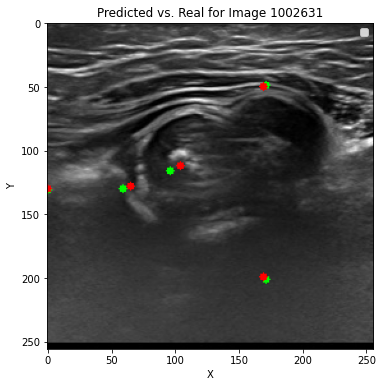

In [117]:
# 이미지 ID
img_id = 1002631
img_data = result_df[result_df['img'] == img_id]

# 이미지에 점 찍기
plot_image_with_points(img_id, img_data)

In [123]:
%cd /home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1

/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1


In [120]:
img_id = 1001834
img_data = result_df[result_df['img'] == img_id]
img_data

,img,label,predict_x,predict_y,real_x,real_y,rmse
2561,1001834,2,0.245269,0.502155,0.230469,0.507812,0.015845
2562,1001834,3,0.376800,0.464129,0.375000,0.453125,0.011151
2563,1001834,4,0.654877,0.208397,0.667969,0.191406,0.021449
2564,1001834,1,0.000000,0.510044,0.000000,0.511719,0.001675
2565,1001834,5,0.670528,0.787994,0.667969,0.785156,0.003821


In [135]:
df[df['image_name'] == '1001834']

,image_name,label,x_predict,y_predict,width,height,x_real,y_real
2561,1001834,2,0.230545,0.507085,0.125521,0.125648,0.230469,0.507812
2562,1001834,3,0.374738,0.453548,0.124068,0.123905,0.375000,0.453125
2563,1001834,4,0.668628,0.191422,0.125169,0.126791,0.667969,0.191406
2564,1001834,1,0.015409,0.512197,0.030795,0.124245,0.000000,0.511719
2565,1001834,5,0.668233,0.785106,0.124330,0.123518,0.667969,0.785156


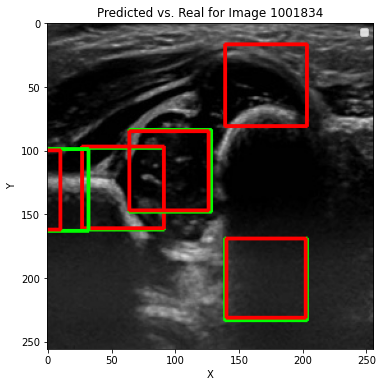

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image


# 이미지 경로
image_path = "/home/dragon82/dragon82/seoyeon/ultralytics/ultralytics/datasets/cancer1/images/test/"

def plot_image_with_points(img_id, img_data):
    # 이미지 불러오기
    image = cv2.imread(image_path + f"{img_id}.jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image from BGR to RGB (matplotlib uses RGB)

    # 이미지에 점 찍기
    for i in range(len(img_data)):
        l=32
        xp,yp = int(img_data.iloc[i]['x_predict'] * image.shape[1]), int(img_data.iloc[i]['y_predict'] * image.shape[0])
        wp,hp = int(img_data.iloc[i]['width'] * image.shape[1]), int(img_data.iloc[i]['height'] * image.shape[0])
        xr,yr = (int(img_data.iloc[i]['x_real'] * image.shape[1]), int(img_data.iloc[i]['y_real'] * image.shape[0]))
        l = 32
        x1 = xr - l  # 왼쪽 상단 좌표 
        y1 = yr - l # 왼쪽 상단 좌표 y
        x2 = xr + l # 오른쪽 하단 좌표 
        y2 = yr + l    # 오른쪽 하단 좌표 y
        
        xp1 = xp - wp # 왼쪽 상단 좌표 
        yp1 = yp - hp   # 왼쪽 상단 좌표 y
        xp2 = xp + wp #  # 오른쪽 하단 좌표 
        yp2 = yp + hp   # 오른쪽 하단 좌표 y
       
       

        
      # Circle with filled center
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.rectangle(image, (xp1, yp1), (xp2, yp2), (255, 0, 0), 2) #예측값

    # 이미지 보여주기
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Predicted vs. Real for Image {img_id}')
    plt.legend(['Predicted', 'Real'])
    plt.grid(False)
    plt.show()

# 이미지 ID
img_id = 1001834
img_data = df[df['image_name'] == '1001834']

# 이미지에 점 찍기
plot_image_with_points(img_id, img_data)

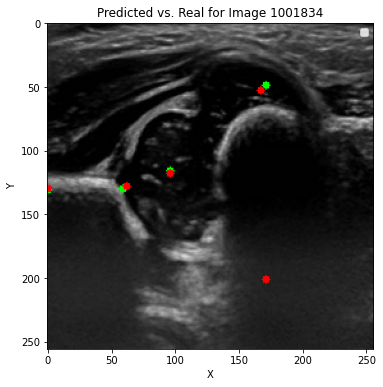

In [118]:
# 이미지 ID
img_id = 1001834
img_data = result_df[result_df['img'] == img_id]

# 이미지에 점 찍기
plot_image_with_points(img_id, img_data)

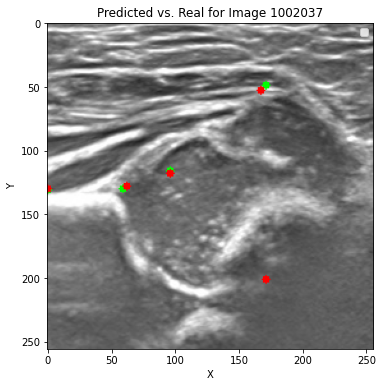

In [119]:
# 이미지 ID
img_id = 1002037
img_data = result_df[result_df['img'] == img_id]

# 이미지에 점 찍기
plot_image_with_points(img_id, img_data)